# Decoding population activity

**Imports**

In [1]:
%matplotlib inline
from sym_model import Population, sigmoid

import sys
import seaborn as sns
import umap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.insert(0, './model')

from model import decoding
from model import persistence
from utils import get_orientation_phase_grid

## Getting the data

**Sampling the activity using the model**

In [2]:
limit = 500
# n_theta, n_phi = 18, 24
n_theta, n_phi = 36, 72
# n_theta, n_phi = 9, 12
step_phi, step_theta = 360 // n_phi, 180 // n_theta
N = 40 # number of cells

In [3]:
grid = get_orientation_phase_grid(step_phi, step_theta)
grid = grid.reshape((-1, 2))
print(grid[0], grid[-1], grid.shape)

[0. 0.] [3.05432619 6.19591884] (2592, 2)


In [4]:
population = Population.random(N)

In [5]:
phi_deg, theta_deg = grid[:, 1] * 180 / np.pi, grid[:, 0] * 180 / np.pi

In [6]:
# res = population.sample_responses(limit, custom_grid=grid, use_sigmoid=False)
# res, phi_deg, theta_deg = res[:, :, 0], res[:, 0, 1], res[:, 0, 2]

In [7]:
res = np.abs(population.response_func(grid[:, 1], grid[:, 0]).swapaxes(0, 1)) * 10

In [8]:
phi_reorder = sorted(list(range(len(phi_deg[:limit]))), key=lambda x: phi_deg[x])
theta_reorder = sorted(list(range(len(theta_deg[:limit]))), key=lambda x: theta_deg[x])

In [9]:
res.shape

In [10]:
res_reshaped = res.reshape((n_phi, n_theta, -1))

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

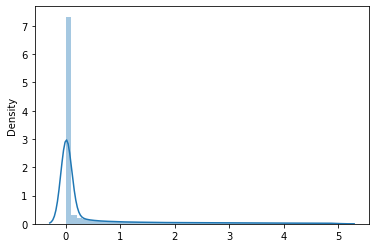

In [11]:
sns.distplot(res.ravel())

## Plotting joint tunings

In [12]:
phase_linspace = np.linspace(0, 360, n_phi)
orientation_linspace = np.linspace(0, 180, n_theta)

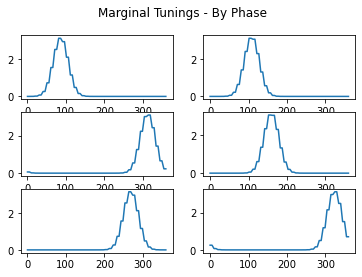

In [13]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Marginal Tunings - By Phase')
for i in range(6):
    ax[i].plot(phase_linspace, res_reshaped.mean(1)[:, i])

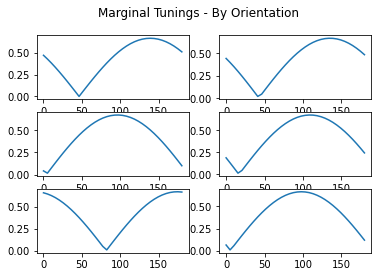

In [14]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Marginal Tunings - By Orientation')
for i in range(6):
    ax[i].plot(orientation_linspace, res_reshaped.mean(0)[:, i])

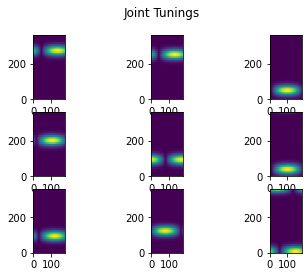

In [15]:
fig, ax = plt.subplots(3, 3)
ax = ax.flatten()
# set title
fig.suptitle('Joint Tunings')
for i in range(9):
    ax[i].imshow(res_reshaped[:, :, i], cmap='viridis', extent=[0, 180, 0, 360])

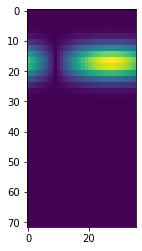

In [16]:
plt.imshow(res_reshaped[:, :, 0], cmap='viridis')

## PCA

In [20]:
res_df = pd.DataFrame(res, columns=['x' + str(i) for i in range(N)])

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns

<AxesSubplot:>

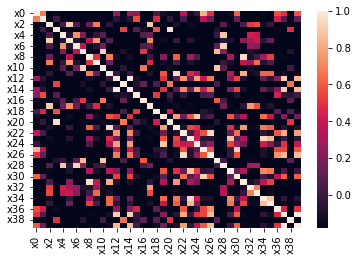

In [22]:
sns.heatmap(res_df.corr())

Let's take 6 components

In [23]:
N_COMP = 4
pca = PCA(n_components=N_COMP)
pca.fit(res_df)
data_pca = pca.transform(res_df)
data_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(N_COMP)])
data_pca.head()

PC1       PC2       PC3       PC4
0  1.152136  6.882894 -1.545937 -0.027478
1  1.081195  6.691970 -1.446043 -0.080447
2  0.996579  6.447147 -1.338007 -0.133982
3  0.937118  6.268196 -1.259540 -0.170500
4  0.938863  6.362411 -1.261050 -0.188440

In [24]:
data_pca.shape

## UMAP decoding

In [25]:
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(data_pca.to_numpy())

In [26]:
# %matplotlib notebook
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1])
# plt.show()

In [27]:
# embedding.shape

## Cohomological decoding

In [37]:
step = 5

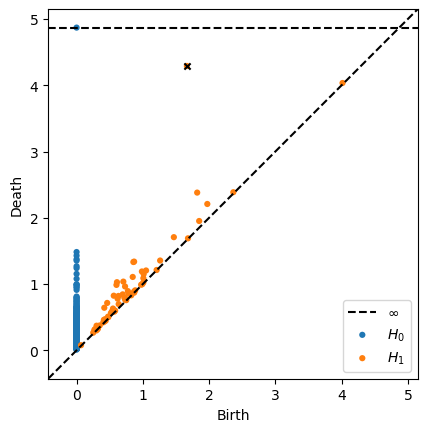

Decoding... done


In [38]:
param_1 = decoding.cohomological_parameterization(data_pca[::step]).to_numpy()

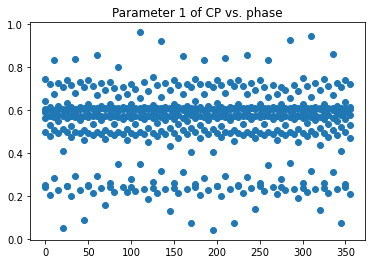

In [43]:
%matplotlib inline
plt.title("Parameter 1 of CP vs. phase")
plt.scatter(phi_deg[::step], param_1)

#### Orientation is decoded:

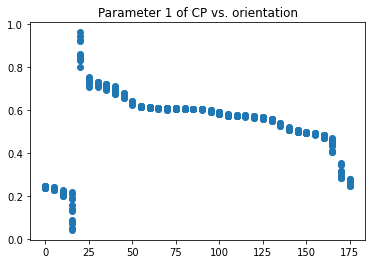

In [42]:
plt.title("Parameter 1 of CP vs. orientation")
plt.scatter(theta_deg[::step], param_1)

In [44]:
data_without_features = decoding.remove_feature(data_pca[::step].to_numpy(), pd.DataFrame(param_1))

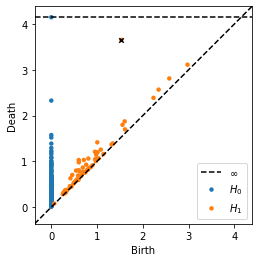

Decoding... done


In [45]:
param_2 = decoding.cohomological_parameterization(
    pd.DataFrame(data_without_features)).to_numpy()

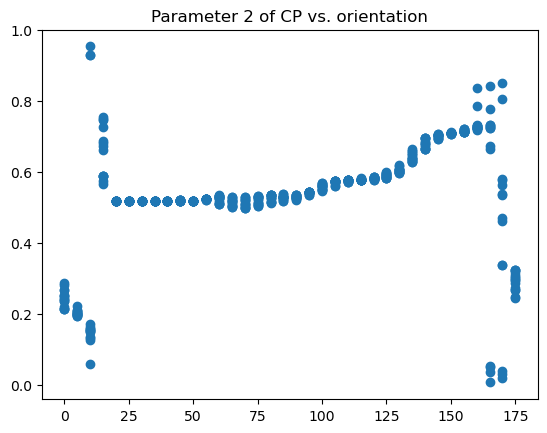

In [48]:
plt.title("Parameter 2 of CP vs. orientation")
plt.scatter(theta_deg[::step], param_2)

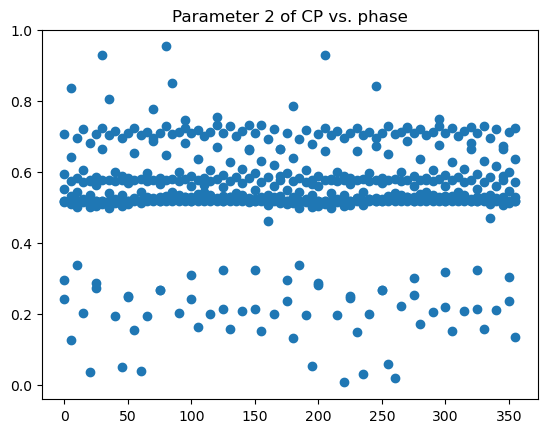

In [51]:
plt.title("Parameter 2 of CP vs. phase")
plt.scatter(phi_deg[::step], param_2)